# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">7. Integration and Final Predictions</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546   |

---

### **8. Integration and Final Predictions Notebook**  
**Description:**  
This notebook integrates and compares the results of both **hierarchical classification** and **flat classification** approaches to produce the final outputs and evaluate the entire pipeline.  

Key steps include:  
- **Combining Predictions:** Merge outputs from both approaches to enable a side-by-side comparison.  
- **Performance Evaluation:** Compare flat and hierarchical models using metrics such as accuracy, F1-score, precision, recall, and confusion matrices.  
- **Analysis:** Discuss the advantages, disadvantages, and trade-offs of each approach. Highlight scenarios where one approach outperforms the other.  
- **Output:** Save the final predictions from both approaches for deployment, further reporting, or stakeholder presentation.  

This notebook serves as the final step in the pipeline, providing a detailed evaluation of the two modeling strategies and ensuring clarity on their relative performance and practical implications.  

---


## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Final Hierarchical Modeling Predictions](#chapter2)
* [3. Performance Evaluation](#chapter3)


# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>
[Back to ToC](#toc)<br>

In [1]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')

# 2. Final Hierarchical Modeling Predictions <a class="anchor" id="chapter2"></a>
[Back to ToC](#toc)<br>

In this section, we will load the final `df_test` containing the predictions, perform basic visualizations of the predicted test targets, and prepare the results for submission to Kaggle.

In [9]:
X_test_final_combined = pd.read_csv("../processed_datasets/y_test_with_predictions.csv", index_col="Claim Identifier")

In [10]:
X_test_final_combined.head()

,Pred_notebook_5
Claim Identifier,
6165911,2. NON-COMP
6166141,4. TEMPORARY
6165907,4. TEMPORARY
6166047,2. NON-COMP
6166102,4. TEMPORARY


Let's create a simple plot to visualize the value counts of the predicted target variable from the df_test dataset.

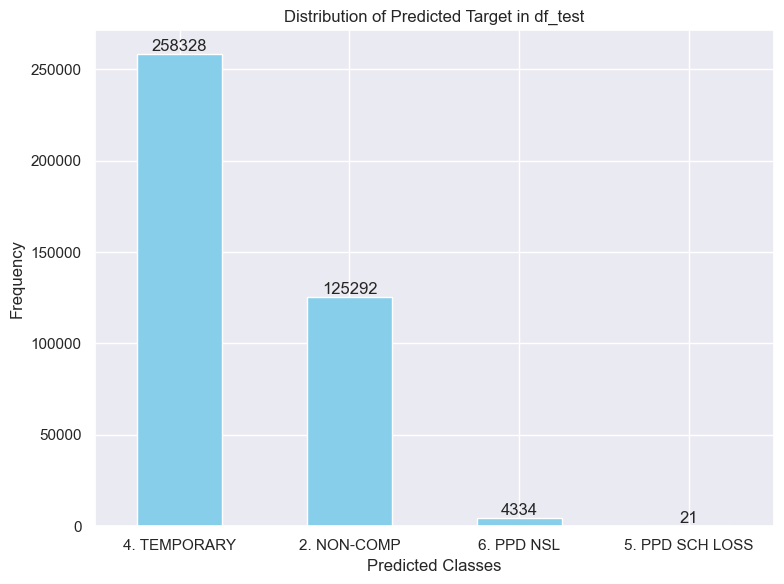

In [11]:
value_counts = X_test_final_combined['Pred_notebook_5'].value_counts()

# Plotting the value counts
plt.figure(figsize=(8, 6))
bars = value_counts.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Predicted Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Target in df_test')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal

# Add count value above each bar
for bar in bars.patches:
    height = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{int(height)}', 
             ha='center', va='bottom')  # Position the count value above the bar

# Show the plot
plt.tight_layout()
plt.show()


To prepare the final dataset for submission, we will rename the column Pred_notebook_5 to 'Claim Injury Type' and save the dataset to a CSV file without including the index.

In [13]:
# Rename the column
X_test_final_combined.rename(columns={'Pred_notebook_5': 'Claim Injury Type'}, inplace=True)

# Save to CSV without including the index
X_test_final_combined.to_csv('submission.csv', index=True)

# 3. Performance Evaluation <a class="anchor" id="chapter3"></a>
[Back to ToC](#toc)<br>

In this section, we will plot graphs to compare the overall macro F1 score on both the training and validation sets for our approach. First, we will visualize the F1 scores from our hierarchical modeling across different levels (from notebooks 4, 5, and 6), calculate the average score, and then compute the F1 score for the flat model.

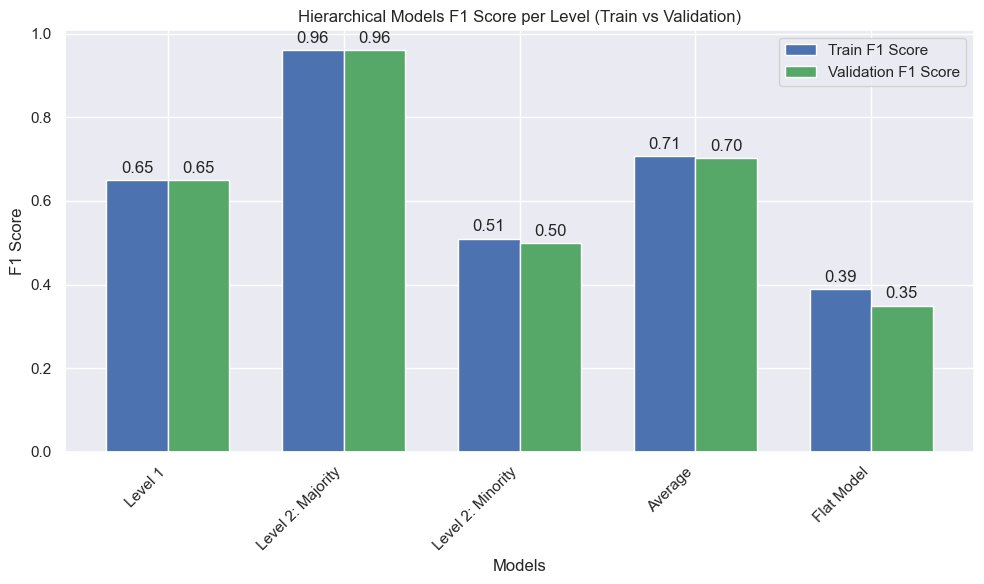

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = ["Level 1", "Level 2: Majority", "Level 2: Minority", "Average", "Flat Model"]
train_f1_scores = [0.65, 0.96, 0.51, np.mean([0.65, 0.96, 0.51]), 0.39]  # Adding average and Flat Model
val_f1_scores = [0.65, 0.96, 0.50, np.mean([0.65, 0.96, 0.50]), 0.35]  # Adding average and Flat Model

# Bar width and positions
bar_width = 0.35
x = np.arange(len(labels))  # X positions for the bars

# Plot for hierarchical models
plt.figure(figsize=(10, 6))
train_bars = plt.bar(x - bar_width/2, train_f1_scores, bar_width, color='b', label='Train F1 Score')
val_bars = plt.bar(x + bar_width/2, val_f1_scores, bar_width, color='g', label='Validation F1 Score')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Hierarchical Models F1 Score per Level (Train vs Validation)')
plt.xticks(x, labels, rotation=45, ha='right')  # Add model labels on x-axis
plt.legend()

# Add F1 score values above the bars for train
for bar in train_bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')  # Position text above the bar

# Add F1 score values above the bars for validation
for bar in val_bars:
    yval = bar.get_height()  # Get the height of each bar
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')  # Position text above the bar

# Adjust layout and show plot
plt.tight_layout()  # Adjust layout to prevent text overlap
plt.show()

We will also visualize the distribution of Claim Injury Types predicted by the Hierarchical Model compared to those predicted by the Flat Model.

In [15]:
X_test_final_flatmodel = pd.read_csv("flat_submission.csv", index_col="Claim Identifier")

In [16]:
X_test_final_flatmodel.head()

,Claim Injury Type
Claim Identifier,
6165911,4. TEMPORARY
6166141,4. TEMPORARY
6165907,4. TEMPORARY
6166047,4. TEMPORARY
6166102,4. TEMPORARY


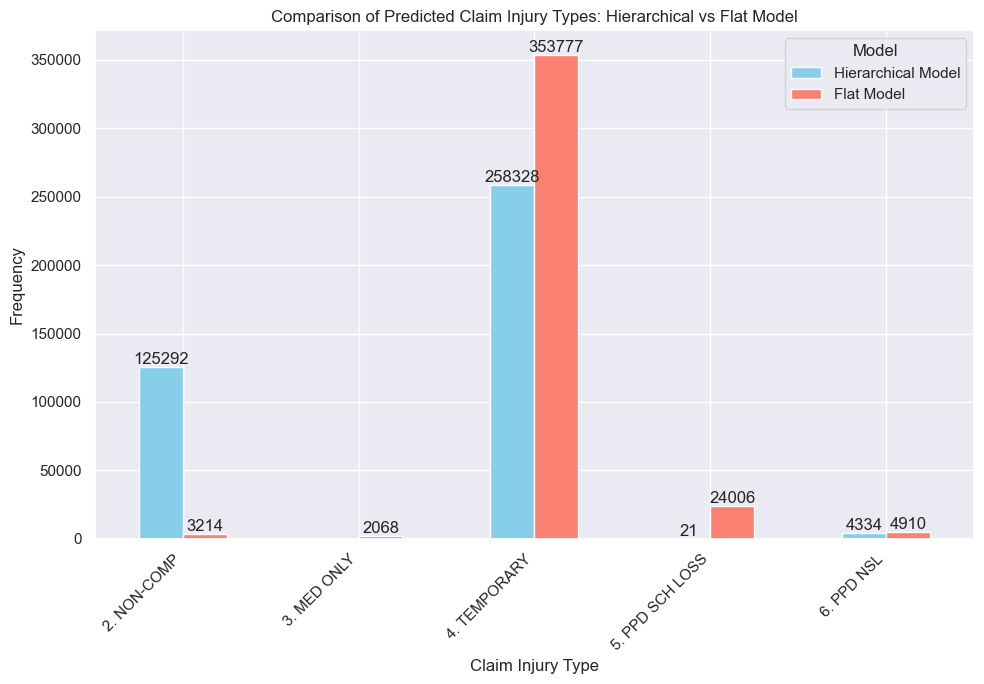

In [17]:
import matplotlib.pyplot as plt

# Calculate value counts for both hierarchical and flat model predictions
combined_counts = X_test_final_combined['Claim Injury Type'].value_counts()
flatmodel_counts = X_test_final_flatmodel['Claim Injury Type'].value_counts()

# Combine the value counts into a DataFrame for easier plotting
comparison_df = pd.DataFrame({
    'Hierarchical Model': combined_counts,
    'Flat Model': flatmodel_counts
}).fillna(0)  # Fill missing values with 0 for consistency

# Plotting side-by-side bar chart
comparison_df.plot(kind='bar', figsize=(10, 7), color=['skyblue', 'salmon'])

# Adding labels and title
plt.xlabel('Claim Injury Type')
plt.ylabel('Frequency')
plt.title('Comparison of Predicted Claim Injury Types: Hierarchical vs Flat Model')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Model')

# Add value annotations to the bars
for i, bar_group in enumerate(plt.gca().containers):
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{int(height)}', 
                     ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()
